<a href="https://colab.research.google.com/github/pradyutsingh/Emotion-analyser/blob/master/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import cv2

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
from keras.models import load_model

Now lets import the dataset.
The original data taken from kaggle was in a csv format of the dimension (1,2388) which had to be converted into images of shape (48,48)


In [0]:
train_images = np.load('/content/drive/My Drive/emotion_detect/train_images1.npy')
validation_images = np.load('/content/drive/My Drive/emotion_detect/validation_images1.npy')
test_images = np.load('/content/drive/My Drive/emotion_detect/test_images1.npy')

In [0]:
emotions = pd.read_csv('/content/drive/My Drive/emotion_detect/emotions.csv')

In [7]:
print(len(train_images))
print(len(validation_images))
print(len(test_images))
print(len(emotions))

28709
3589
3589
35886


**OUTPUT LABELS 
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)**

In [0]:
y_train = emotions[:train_images.shape[0]].values
y_val = emotions[train_images.shape[0]:train_images.shape[0] + validation_images.shape[0]].values
y_test = emotions[train_images.shape[0] + validation_images.shape[0]: ].values

In [9]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3588, 1)


In [10]:
#now one hot encoding the data
y_train_enc =tf.keras.utils.to_categorical(y_train, num_classes=7)
y_val_enc =tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_enc =tf.keras.utils.to_categorical(y_test, num_classes=7)

print(y_train_enc.shape)
print(y_val_enc.shape)
print(y_test_enc.shape)

(28709, 7)
(3589, 7)
(3588, 7)


In [0]:
def show_img(image):
  img = image.reshape(48,48)
  plt.imshow(img,cmap='gray')

Emotion[2]
(28709, 48, 48)


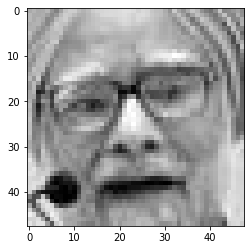

In [12]:
show_img(train_images[1])
print('Emotion' + str(y_train[1]))
print(train_images.shape)

Emotion[4]


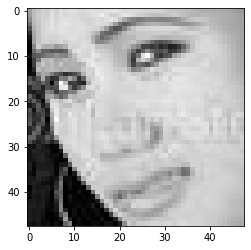

In [13]:
show_img(validation_images[1])
print('Emotion' + str(y_val[1]))

Emotion[6]


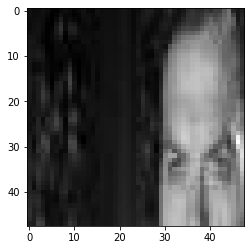

In [14]:
show_img(test_images[1])
print('Emotion' + str(y_test[1]))

In [0]:
train_images = np.expand_dims(train_images,3)
validation_images = np.expand_dims(validation_images,3)
test_images= np.expand_dims(test_images,3)



In [16]:
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [0]:
ckpt =tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/emotion_detect/best_weights.hdf5',
                                         verbose=1,save_best_only=True)


In [0]:
model = tf.keras.Sequential()

#1
model.add(layers.Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, 3, padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

#2
model.add(layers.Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
model.add(layers.Dropout(0.25))

# 3
model.add(layers.Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
model.add(layers.Dropout(0.25))

# FC layers
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7))
model.add(layers.Activation('softmax'))

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        2

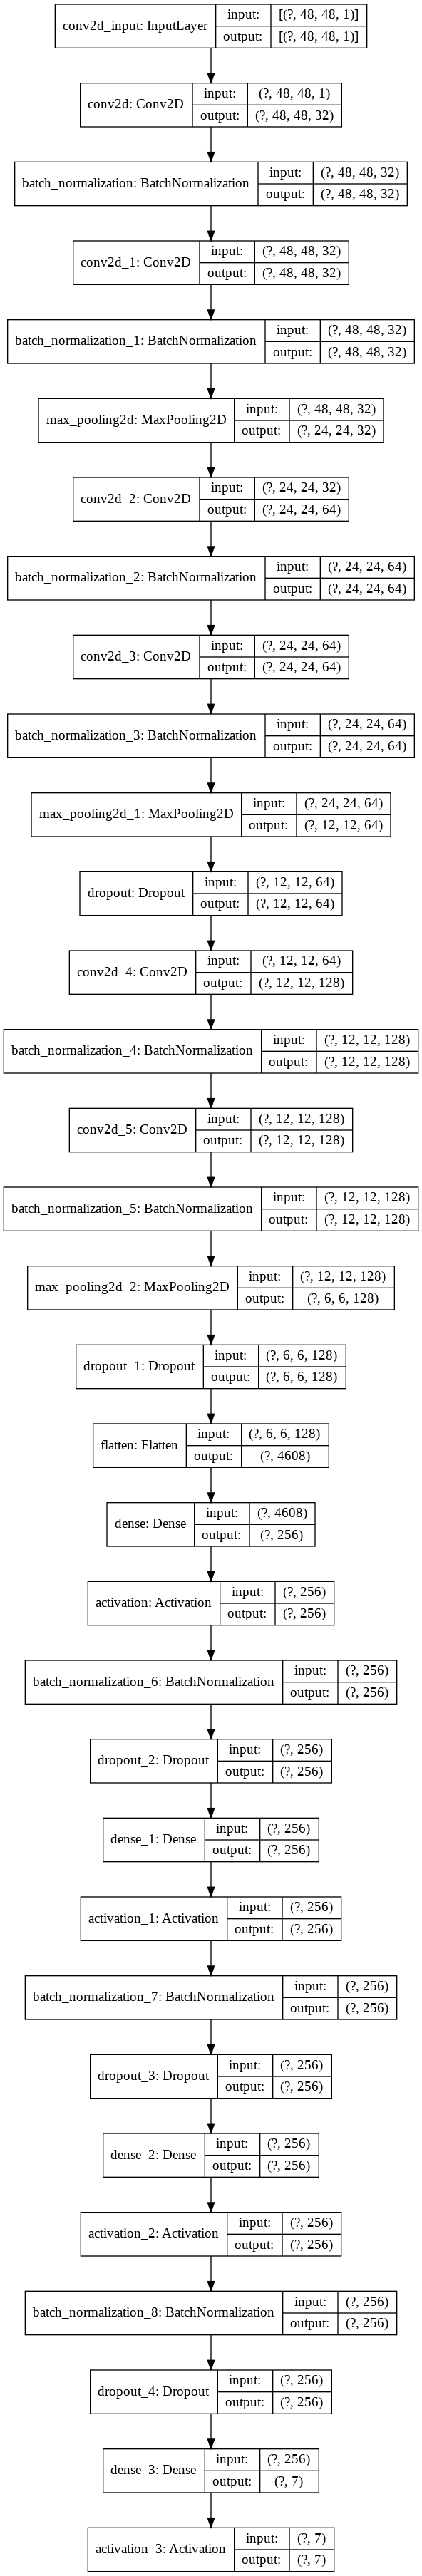

In [20]:
keras.utils.plot_model(model,to_file='mymodelplot.png',show_shapes=True)

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [50]:
i=0
for i in range(3):
  hist = model.fit(train_images, y_train_enc, batch_size=128, epochs=5, verbose=1,
                 validation_data=(validation_images,y_val_enc),shuffle=True, callbacks=[ckpt])

  model.save_weights('/content/drive/My Drive/emotion_detect/weights1.h5')
  model.save('/content/drive/My Drive/emotion_detect/model1.h5')

Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.8240
Epoch 00001: val_loss did not improve from 1.81040
225/225 [==============================] - 9s 42ms/step - loss: 0.4973 - accuracy: 0.8240 - val_loss: 3.2014 - val_accuracy: 0.1814
Epoch 2/5
225/225 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.8217
Epoch 00002: val_loss did not improve from 1.81040
225/225 [==============================] - 9s 42ms/step - loss: 0.5002 - accuracy: 0.8217 - val_loss: 3.2864 - val_accuracy: 0.1847
Epoch 3/5
225/225 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.8250
Epoch 00003: val_loss did not improve from 1.81040
225/225 [==============================] - 9s 42ms/step - loss: 0.4935 - accuracy: 0.8250 - val_loss: 3.2316 - val_accuracy: 0.1806
Epoch 4/5
225/225 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.8254
Epoch 00004: val_loss did not improve from 1.81040
225/225 [===========

In [51]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [53]:
train_accuracy = hist.history['accuracy']
print('Training Accuracy: ', train_accuracy[-1])




Training Accuracy:  0.828799307346344


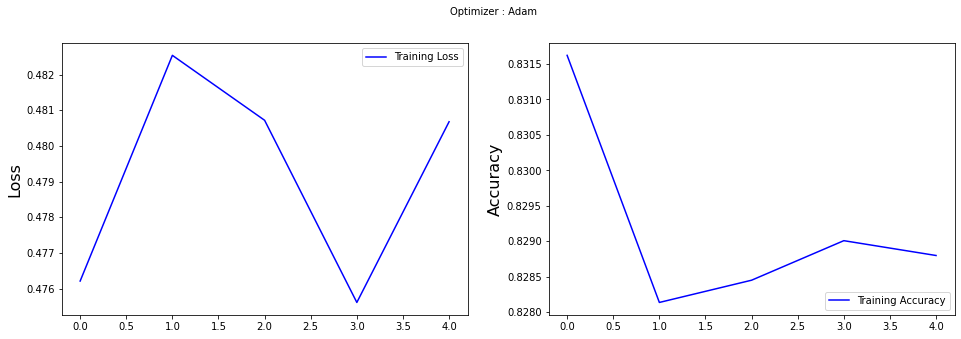

In [81]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.legend(loc='lower right')
plt.show()

In [0]:

# read image 
images = []
for filename in os.listdir('/content/drive/My Drive/emotion_detect/test_pics'):
    path = os.path.join('/content/drive/My Drive/emotion_detect/test_pics', filename)
    images.append(cv2.imread(path, -1))

In [0]:
predictions = []
for img in images:
    # change to greyscale
    curr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    curr_img = cv2.resize(curr_img, (48,48))
    curr_img = np.reshape(curr_img, (1, 48, 48, 1))
    predictions.append(np.argmax(model.predict(curr_img)))

In [0]:

# list of given emotions
EMOTIONS = ['Angry', 'Disgusted', 'Fearful',
            'Happy', 'Sad', 'Surprised', 'Neutral']

In [0]:
for i in range(4):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)


Predicted Emotion: Neutral


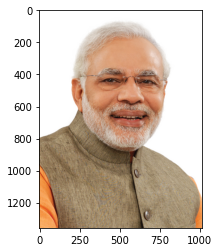

In [76]:
plt.imshow(images[0])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[0]]))

Predicted Emotion: Neutral


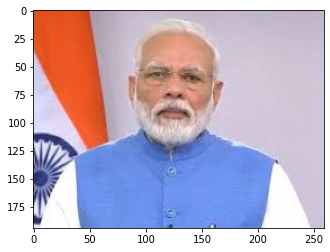

In [77]:
plt.imshow(images[1])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[1]]))

Predicted Emotion: Happy


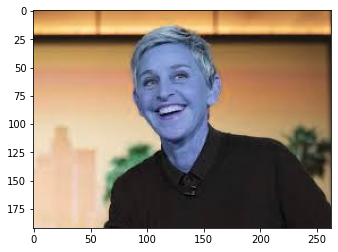

In [80]:
plt.imshow(images[4])
print('Predicted Emotion: ' + str(EMOTIONS[predictions[4]]))